<a href="https://colab.research.google.com/github/msymhkr/mainopen/blob/main/SRGAN_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Convert Images to hr and lr

In [2]:
import os
from PIL import Image

hrp, lrp = 100, 25     # high and low resolution pixels

def resize_and_save_images(input_directory, high_res_directory, low_res_directory):
    # Create output directories if they don't exist
    os.makedirs(high_res_directory, exist_ok=True)
    os.makedirs(low_res_directory, exist_ok=True)
    # Loop through all images in the input directory
    for filename in os.listdir(input_directory):
        if filename.lower().endswith(('.jpg', '.png')):  # Add more formats if necessary
            img_path = os.path.join(input_directory, filename)
            with Image.open(img_path) as img:
                # Resize for high and low resolution
                high_res_img = img.resize((hrp, hrp), Image.Resampling.LANCZOS)
                high_res_img.save(os.path.join(high_res_directory, filename))
                low_res_img = img.resize((lrp, lrp), Image.Resampling.LANCZOS)
                low_res_img.save(os.path.join(low_res_directory, filename))

input_directory1 = '/content/drive/MyDrive/sample_file/srgan_train_samples'
high_res_directory1 = '/content/drive/MyDrive/sample_file/srgan_train_samples/srgan_train_hr'
low_res_directory1 = '/content/drive/MyDrive/sample_file/srgan_train_samples/srgan_train_lr'
resize_and_save_images(input_directory1, high_res_directory1, low_res_directory1)

input_directory2 = '/content/drive/MyDrive/sample_file/srgan_test_samples'
high_res_directory2 = '/content/drive/MyDrive/sample_file/srgan_test_samples/srgan_test_hr'
low_res_directory2 = '/content/drive/MyDrive/sample_file/srgan_test_samples/srgan_test_lr'
resize_and_save_images(input_directory2, high_res_directory2, low_res_directory2)

To Normalize the images

In [3]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras import Model
from keras.layers import Conv2D, PReLU, BatchNormalization, Flatten
from keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add

def load_and_preprocess_image(image_path, target_size):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    # # Alternatively, normalize to the range [-1, 1]
    # img_array = (img_array / 127.5) - 1.0
    # Normalize to the range [0, 1]
    img_array = img_array / 255.0
    return img_array

def load_images_from_directory(directory, target_size):
    images = []
    for filename in os.listdir(directory):
        if filename.lower().endswith(('.jpg', '.png')):  # Add more formats if necessary
            img_path = os.path.join(directory, filename)
            img_array = load_and_preprocess_image(img_path, target_size)
            images.append(img_array)
    return np.array(images)

normalized_train_hr_images = load_images_from_directory(high_res_directory1, (hrp, hrp))
normalized_train_lr_images = load_images_from_directory(low_res_directory1, (lrp, lrp))
normalized_test_hr_images = load_images_from_directory(high_res_directory2, (hrp, hrp))
normalized_test_lr_images = load_images_from_directory(low_res_directory2, (lrp, lrp))

lr_ip = Input(shape=(lrp,lrp,3))
hr_ip = Input(shape=(hrp,hrp,3))
train_lr = normalized_train_lr_images # training images arrays normalized between 0 & 1
train_hr = normalized_train_hr_images
test_lr = normalized_test_lr_images # testing images arrays normalized between 0 & 1
test_hr = normalized_test_hr_images

Define Generator

In [8]:
# Residual block
def res_block(ip):
    res_model = Conv2D(64, (3,3), padding = "same")(ip)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    res_model = PReLU(shared_axes = [1,2])(res_model)
    res_model = Conv2D(64, (3,3), padding = "same")(res_model)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    return add([ip,res_model])

# Upscale the image 2x
def upscale_block(ip):
    up_model = Conv2D(256, (3,3), padding="same")(ip)
    up_model = UpSampling2D( size = 2 )(up_model)
    up_model = PReLU(shared_axes=[1,2])(up_model)
    return up_model

# Generator Model
num_res_block = 16
def create_gen(gen_ip):
    layers = Conv2D(64, (9,9), padding="same")(gen_ip)
    layers = PReLU(shared_axes=[1,2])(layers)
    temp = layers
    for i in range(num_res_block):
        layers = res_block(layers)
    layers = Conv2D(64, (3,3), padding="same")(layers)
    layers = BatchNormalization(momentum=0.5)(layers)
    layers = add([layers,temp])
    layers = upscale_block(layers)
    layers = upscale_block(layers)
    op = Conv2D(3, (9,9), padding="same")(layers)
    return Model(inputs=gen_ip, outputs=op)

Define Discriminator Block

In [9]:
#Small block inside the discriminator
def discriminator_block(ip, filters, strides=1, bn=True):
    disc_model = Conv2D(filters, (3,3), strides, padding="same")(ip)
    disc_model = LeakyReLU( alpha=0.2 )(disc_model)
    if bn:
        disc_model = BatchNormalization( momentum=0.8 )(disc_model)
    return disc_model

# Discriminator Model
def create_disc(disc_ip):
    df = 64
    d1 = discriminator_block(disc_ip, df, bn=False)
    d2 = discriminator_block(d1, df, strides=2)
    d3 = discriminator_block(d2, df*2)
    d4 = discriminator_block(d3, df*2, strides=2)
    d5 = discriminator_block(d4, df*4)
    d6 = discriminator_block(d5, df*4, strides=2)
    d7 = discriminator_block(d6, df*8)
    d8 = discriminator_block(d7, df*8, strides=2)
    d8_5 = Flatten()(d8)
    d9 = Dense(df*16)(d8_5)
    d10 = LeakyReLU(alpha=0.2)(d9)
    validity = Dense(1, activation='sigmoid')(d10)
    return Model(disc_ip, validity)

VGG19 Model

In [10]:
from keras.applications import VGG19
# Build the VGG19 model upto 10th layer
# Used to extract the features of high res imgaes
def build_vgg(hr_shape):
    # vgg = VGG19(weights="imagenet")
    # vgg.outputs = [vgg.layers[9].output]
    # img = Input(shape=hr_shape)
    # img_features = vgg(img)
    # return Model(img, img_features)
    vgg = VGG19(weights="imagenet", include_top=False, input_shape=hr_shape)
    return Model(inputs=vgg.inputs, outputs=vgg.layers[10].output)

Combined Model

In [11]:
# Attach the generator and discriminator
def create_comb(gen_model, disc_model, vgg, lr_ip, hr_ip):
    gen_img = gen_model(lr_ip)
    gen_features = vgg(gen_img)
    disc_model.trainable = False
    validity = disc_model(gen_img)
    return Model([lr_ip, hr_ip],[validity,gen_features])

Declare models

In [12]:
generator = create_gen(lr_ip)
discriminator = create_disc(hr_ip)
discriminator.compile(loss="binary_crossentropy", optimizer="adam",
  metrics=['accuracy'])
vgg = build_vgg((hrp, hrp, 3))
vgg.trainable = False
gan_model = create_comb(generator, discriminator, vgg, lr_ip, hr_ip)
gan_model.compile(loss=["binary_crossentropy","mse"], loss_weights=
  [1e-3, 1], optimizer="adam")
gan_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 25, 25, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional (Functional)   │ (None, 100, 100, 3)    │      2,044,291 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 100, 100, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_1 (Functional) │ (None, 1)              │     30,384,961 │ functional[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_2 (Functional) │ (None, 25, 25, 256)    │      2,325,568 │ functional[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 34,754,820 (132.58 MB)

 Trainable params: 2,040,067 (7.78 MB)

 Non-trainable params: 32,714,753 (124.80 MB)

Sample the training data into small batches

In [17]:
batch_size = 1
train_lr_batches = []
train_hr_batches = []
for it in range(int(train_hr.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(train_hr[start_idx:end_idx])
    train_lr_batches.append(train_lr[start_idx:end_idx])
train_lr_batches = np.array(train_lr_batches)
train_hr_batches = np.array(train_hr_batches)

Training the model

In [18]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the checkpoint callback
checkpoint_path = "/content/drive/MyDrive/Colab Notebooks/save_model/SRGAN-1_save/model_weights.weights.h5"
model_checkpoint = ModelCheckpoint(
          checkpoint_path,
          save_weights_only=True,    # Save only the weights, not the entire model
          monitor='val_loss',      # Monitor validation loss
          save_best_only=True,     # Save only the best model
          mode='min',          # Save when the monitored quantity is minimized
          verbose=1)
epochs = 5
for e in range(epochs):
    gen_label = np.zeros((batch_size, 1))
    real_label = np.ones((batch_size, 1))
    g_losses = []
    d_losses = []
    for b in range(len(train_hr_batches)):
        lr_imgs = train_lr_batches[b]
        hr_imgs = train_hr_batches[b]
        gen_imgs = generator.predict_on_batch(lr_imgs)

        #Train the discriminator
        discriminator.trainable = True
        d_loss_gen = discriminator.train_on_batch(gen_imgs,
          gen_label)
        d_loss_real = discriminator.train_on_batch(hr_imgs,
          real_label)
        discriminator.trainable = False
        d_loss = 0.5 * np.add(d_loss_gen, d_loss_real)
        image_features = vgg.predict(hr_imgs)

        #Train the generator
        g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs],
          [real_label, image_features])
        d_losses.append(d_loss)
        g_losses.append(g_loss)

    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)
    g_loss = np.sum(g_losses, axis=0) / len(g_losses)
    d_loss = np.sum(d_losses, axis=0) / len(d_losses)

    # Save model weights at the end of each epoch
    gan_model.save_weights(checkpoint_path)
    print("epoch:", e+1 ,"g_loss:", g_loss, "d_loss:", d_loss)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_137']
Received: inputs=Tensor(shape=(1, 100, 100, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
epoch: 1 g_loss: 569.1056518554688 d_loss: [15.494736  0.0625  ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
epoch: 2 g_loss: 571.8074951171875 d_loss: [16.95327     0.49285713]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
epoch: 3 g_loss: 461.81036376953125 d_loss: [28.846966   0.4497475]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
epoch: 4 g_loss: 388.75860595703125 d_loss: [20.894566   0.5837226]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
epoch: 5 g_loss: 339.64862060546875 d_loss: [16.353756  0.674484]


Evaluate the model

In [20]:
label = np.ones((len(test_lr),1))
test_features = vgg.predict(test_hr)
eval,_,_ = gan_model.evaluate([test_lr, test_hr], [label,test_features])
gan_model.save('/content/drive/MyDrive/Colab Notebooks/save_model/SRGAN-1_save/final_model_weights.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 834ms/step - functional_1_loss: 0.0000e+00 - functional_2_loss: 185.6128 - loss: 185.6128


Predict the output

In [22]:
gan_model.load_weights
test_prediction = generator.predict_on_batch(test_lr)

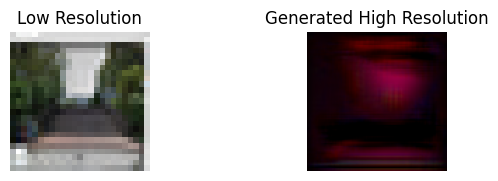

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.subplot(3, 5, 1)
plt.imshow(test_lr[1])
plt.title("Low Resolution")
plt.axis("off")

plt.subplot(3, 5, 2)
plt.imshow(test_prediction[1])
plt.title("Generated High Resolution")
plt.axis("off")

plt.tight_layout()
plt.show()
